Time Series forecasting model

In [1]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

# !pip install prophet==1.1.5




In [3]:
# STEP 1: Prepare monthly time-series data for each crop

import pandas as pd
import os

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/AgriYield_cleaned.csv")

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Convert Yield column to numeric & remove invalid rows
df["Crop_Yield"] = pd.to_numeric(df["Crop_Yield"], errors="coerce")
df = df.dropna(subset=["Date", "Crop_Type", "Crop_Yield"])

# Create output folder to store each crop monthly data
output_folder = "monthly_series_by_crop"
os.makedirs(output_folder, exist_ok=True)

monthly_series_dict = {}   # To store in memory
summary_list = []          # For summary table

# Process each crop separately
for crop, group in df.groupby("Crop_Type"):
    # Resample to monthly average
    monthly = (
        group.set_index("Date")["Crop_Yield"]
        .resample("M")
        .mean()
        .reset_index()
        .rename(columns={"Date": "ds", "Crop_Yield": "y"})
    )

    # Drop missing values
    monthly = monthly.dropna(subset=["y"]).reset_index(drop=True)

    # Store in dictionary (for model training later)
    monthly_series_dict[crop] = monthly

    # Save to CSV
    file_name = crop.replace(" ", "_").replace("/", "_") + "_monthly.csv"
    monthly.to_csv(os.path.join(output_folder, file_name), index=False)

    # Add to summary
    summary_list.append([
        crop,
        len(monthly),
        monthly["ds"].min(),
        monthly["ds"].max()
    ])

# Create summary table
summary_df = pd.DataFrame(summary_list, columns=[
    "Crop Name", "Monthly Records", "Start Date", "End Date"
])

print("✅ Step 1 Completed Successfully")
print(f"📁 Monthly files saved in: {output_folder}")
print("\n📊 Dataset Summary:\n")
print(summary_df)


/tmp/ipython-input-3-1158435990.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipython-input-3-1158435990.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipython-input-3-1158435990.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipython-input-3-1158435990.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipython-input-3-1158435990.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


✅ Step 1 Completed Successfully
📁 Monthly files saved in: monthly_series_by_crop

📊 Dataset Summary:

   Crop Name  Monthly Records Start Date   End Date
0     Barley              119 2014-01-31 2023-12-31
1       Corn              120 2014-01-31 2023-12-31
2     Cotton              120 2014-01-31 2023-12-31
3     Potato              120 2014-01-31 2023-12-31
4       Rice              120 2014-01-31 2023-12-31
5    Soybean              120 2014-01-31 2023-12-31
6  Sugarcane              120 2014-01-31 2023-12-31
7  Sunflower              120 2014-01-31 2023-12-31
8     Tomato              120 2014-01-31 2023-12-31
9      Wheat              120 2014-01-31 2023-12-31


/tmp/ipython-input-3-1158435990.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipython-input-3-1158435990.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipython-input-3-1158435990.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipython-input-3-1158435990.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")
/tmp/ipython-input-3-1158435990.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


In [4]:
# STEP 2: Seasonality and Stationarity Analysis

import pandas as pd
import glob
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

folder = "monthly_series_by_crop"
files = glob.glob(folder + "/*.csv")

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1]  # p-valuea

def kpss_test(series):
    result = kpss(series, regression='c')
    return result[1]  # p-value

analysis_results = []

for file in files:
    df = pd.read_csv(file)
    crop_name = file.split("/")[-1].replace("_monthly.csv", "").replace("_", " ")

    y = df["y"]

    # ADF & KPSS Tests
    adf_p = adf_test(y)
    kpss_p = kpss_test(y)

    # Determine stationarity interpretation
    if adf_p < 0.05 and kpss_p > 0.05:
        stationarity = "✅ Stationary"
    else:
        stationarity = "⚠️ Not Stationary (Needs Differencing)"

    # Seasonality Strength
    decomposition = seasonal_decompose(y, period=12, model='additive')
    seasonal_strength = decomposition.seasonal.var() / (decomposition.seasonal.var() + decomposition.resid.var())

    analysis_results.append([crop_name, adf_p, kpss_p, seasonality := round(seasonal_strength, 3), stationarity])

# Create output summary table
analysis_df = pd.DataFrame(analysis_results, columns=[
    "Crop Name", "ADF p-value", "KPSS p-value", "Seasonality Strength (0-1)", "Stationarity Result"
])

print("✅ Step 2 Completed\n")
print(analysis_df)


✅ Step 2 Completed

   Crop Name  ADF p-value  KPSS p-value  Seasonality Strength (0-1)  \
0     Cotton     0.085900           0.1                       0.777   
1       Corn     0.076266           0.1                       0.845   
2    Soybean     0.184456           0.1                       0.819   
3      Wheat     0.938040           0.1                       0.517   
4  Sugarcane     0.000138           0.1                       0.734   
5       Rice     0.207009           0.1                       0.744   
6  Sunflower     0.029018           0.1                       0.774   
7     Barley     0.254833           0.1                       0.796   
8     Tomato     0.243944           0.1                       0.735   
9     Potato     0.221084           0.1                       0.748   

                      Stationarity Result  
0  ⚠️ Not Stationary (Needs Differencing)  
1  ⚠️ Not Stationary (Needs Differencing)  
2  ⚠️ Not Stationary (Needs Differencing)  
3  ⚠️ Not Stationary (

/tmp/ipython-input-4-935632566.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/tmp/ipython-input-4-935632566.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/tmp/ipython-input-4-935632566.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/tmp/ipython-input-4-935632566.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/tmp/ipython-input-4

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/vpisrx54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/jpba5oq8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12884', 'data', 'file=/tmp/tmplw8vkpj5/vpisrx54.json', 'init=/tmp/tmplw8vkpj5/jpba5oq8.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_model48ut5uzo/prophet_model-20251111093655.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:36:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



📊 Processing crop: Cotton


09:36:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/0wseegyb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/dk4y7sld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62641', 'data', 'file=/tmp/tmplw8vkpj5/0wseegyb.json', 'init=/tmp/tmplw8vkpj5/dk4y7sld.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_model5aglu1pl/prophet_model-20251111093655.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:36:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:36:56 - cmdstanpy - INFO - Chain [1]

⚠️ No best model selected via CV for Cotton, defaulting to basic Prophet model.


09:37:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


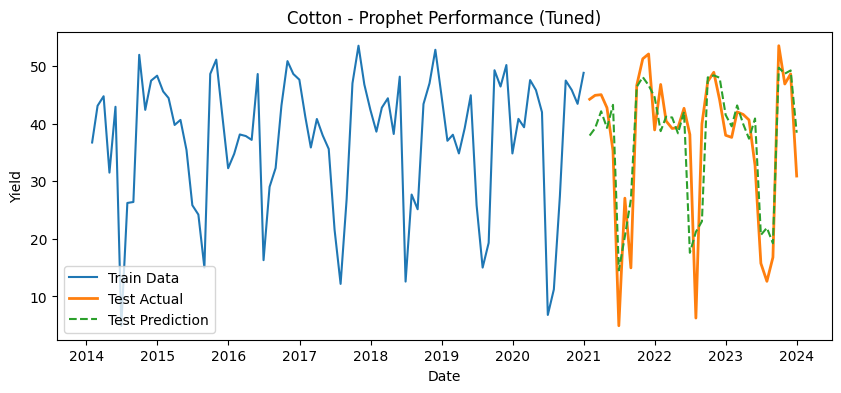

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/zi026tpq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/gn1khre2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37655', 'data', 'file=/tmp/tmplw8vkpj5/zi026tpq.json', 'init=/tmp/tmplw8vkpj5/gn1khre2.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modeluu8tzeu4/prophet_model-20251111093704.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:37:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Saved Prophet model for Cotton at prophet_models/Cotton_prophet.pkl

📊 Processing crop: Corn


09:37:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/6v7hf_ae.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/3og_fivp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58058', 'data', 'file=/tmp/tmplw8vkpj5/6v7hf_ae.json', 'init=/tmp/tmplw8vkpj5/3og_fivp.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modelamekwuua/prophet_model-20251111093705.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:37:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:06 - cmdstanpy - INFO - Chain [1]

⚠️ No best model selected via CV for Corn, defaulting to basic Prophet model.


09:37:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


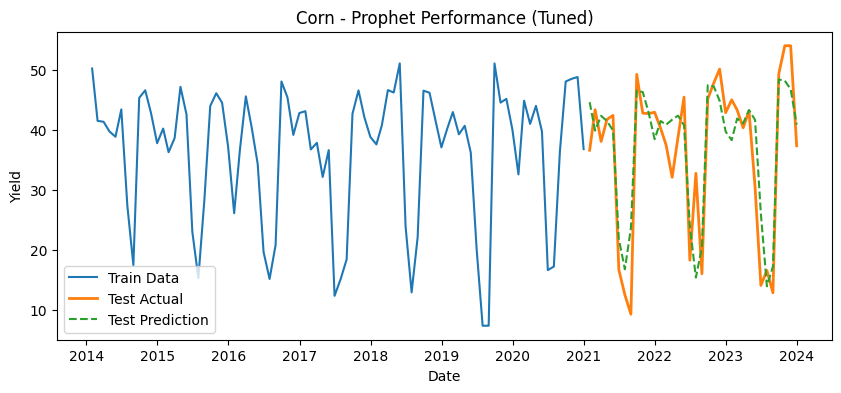

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/6vb4mfln.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/561bxch8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39304', 'data', 'file=/tmp/tmplw8vkpj5/6vb4mfln.json', 'init=/tmp/tmplw8vkpj5/561bxch8.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modelq_plfeys/prophet_model-20251111093715.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:37:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Saved Prophet model for Corn at prophet_models/Corn_prophet.pkl

📊 Processing crop: Soybean


09:37:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/0ciomjke.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/c7ppnbq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50459', 'data', 'file=/tmp/tmplw8vkpj5/0ciomjke.json', 'init=/tmp/tmplw8vkpj5/c7ppnbq7.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modelgisd2fy4/prophet_model-20251111093715.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:37:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:16 - cmdstanpy - INFO - Chain [1]

⚠️ No best model selected via CV for Soybean, defaulting to basic Prophet model.


09:37:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


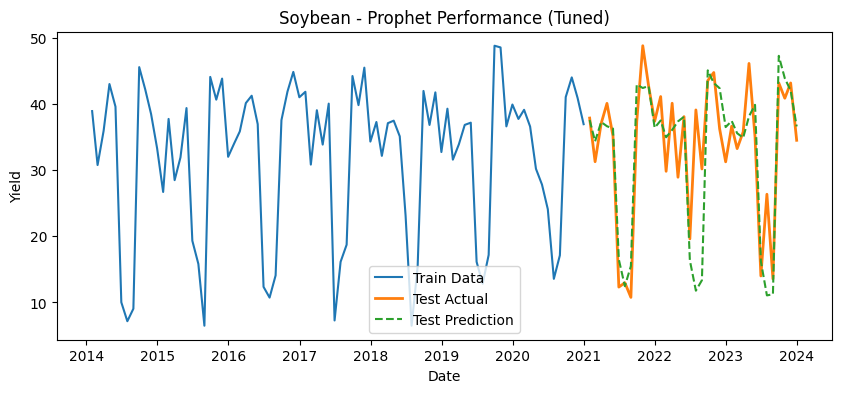

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/kp03th9f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/wqe6p_7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59821', 'data', 'file=/tmp/tmplw8vkpj5/kp03th9f.json', 'init=/tmp/tmplw8vkpj5/wqe6p_7t.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_model8hkr5_sc/prophet_model-20251111093725.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:37:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Saved Prophet model for Soybean at prophet_models/Soybean_prophet.pkl

📊 Processing crop: Wheat


09:37:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/5ozrddjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/hdx2huft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85373', 'data', 'file=/tmp/tmplw8vkpj5/5ozrddjo.json', 'init=/tmp/tmplw8vkpj5/hdx2huft.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modelxzqxtuzx/prophet_model-20251111093725.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:37:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:26 - cmdstanpy - INFO - Chain [1]

⚠️ No best model selected via CV for Wheat, defaulting to basic Prophet model.


09:37:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


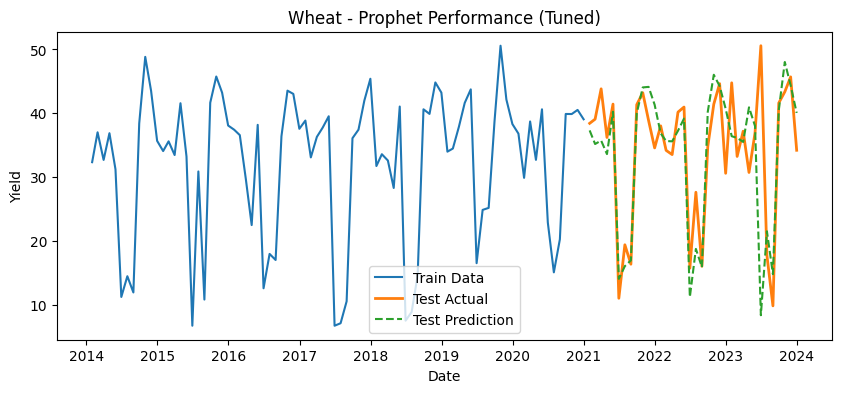

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/5jb7sd38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/0z_i1fs4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10292', 'data', 'file=/tmp/tmplw8vkpj5/5jb7sd38.json', 'init=/tmp/tmplw8vkpj5/0z_i1fs4.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modelha_psmlc/prophet_model-20251111093737.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:37:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Saved Prophet model for Wheat at prophet_models/Wheat_prophet.pkl

📊 Processing crop: Sugarcane


09:37:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/0ehdsbq5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/0vy5fb0q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26124', 'data', 'file=/tmp/tmplw8vkpj5/0ehdsbq5.json', 'init=/tmp/tmplw8vkpj5/0vy5fb0q.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modeli14e_3si/prophet_model-20251111093737.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:37:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:38 - cmdstanpy - INFO - Chain [1]

⚠️ No best model selected via CV for Sugarcane, defaulting to basic Prophet model.


09:37:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


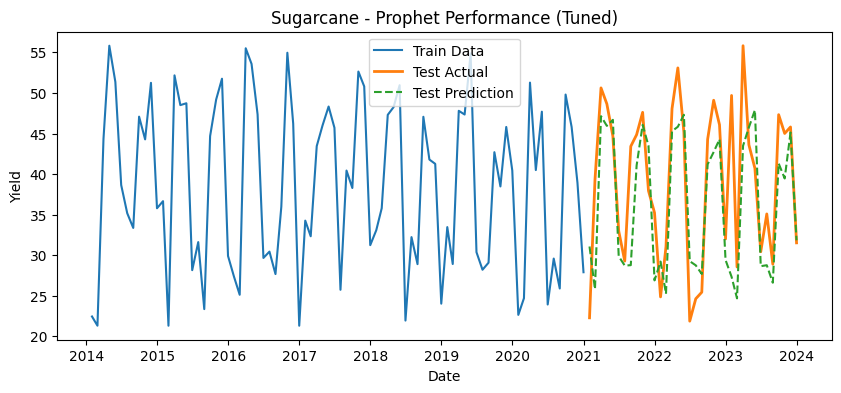

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/68uqy_tk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/hunfx5ul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91641', 'data', 'file=/tmp/tmplw8vkpj5/68uqy_tk.json', 'init=/tmp/tmplw8vkpj5/hunfx5ul.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modelp62e3g3j/prophet_model-20251111093750.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:37:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Saved Prophet model for Sugarcane at prophet_models/Sugarcane_prophet.pkl

📊 Processing crop: Rice


09:37:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/wfla6mcb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/tqsdl8by.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94523', 'data', 'file=/tmp/tmplw8vkpj5/wfla6mcb.json', 'init=/tmp/tmplw8vkpj5/tqsdl8by.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modeleu1sntmm/prophet_model-20251111093751.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:37:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:51 - cmdstanpy - INFO - Chain [1]

⚠️ No best model selected via CV for Rice, defaulting to basic Prophet model.


09:38:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


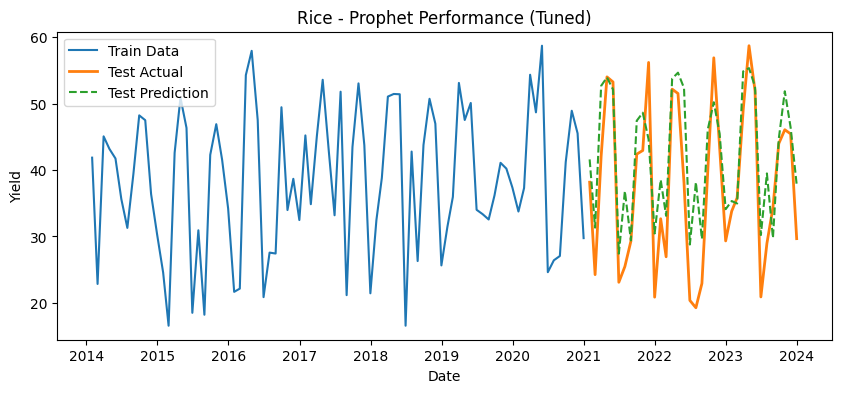

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/krhfd0bm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/1rd50xb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55687', 'data', 'file=/tmp/tmplw8vkpj5/krhfd0bm.json', 'init=/tmp/tmplw8vkpj5/1rd50xb1.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_model8n6dpihd/prophet_model-20251111093803.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:38:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Saved Prophet model for Rice at prophet_models/Rice_prophet.pkl

📊 Processing crop: Sunflower


09:38:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/cc5q36le.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/vq3nic41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32480', 'data', 'file=/tmp/tmplw8vkpj5/cc5q36le.json', 'init=/tmp/tmplw8vkpj5/vq3nic41.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modelz06o2o1h/prophet_model-20251111093803.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:38:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:38:04 - cmdstanpy - INFO - Chain [1]

⚠️ No best model selected via CV for Sunflower, defaulting to basic Prophet model.


09:38:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


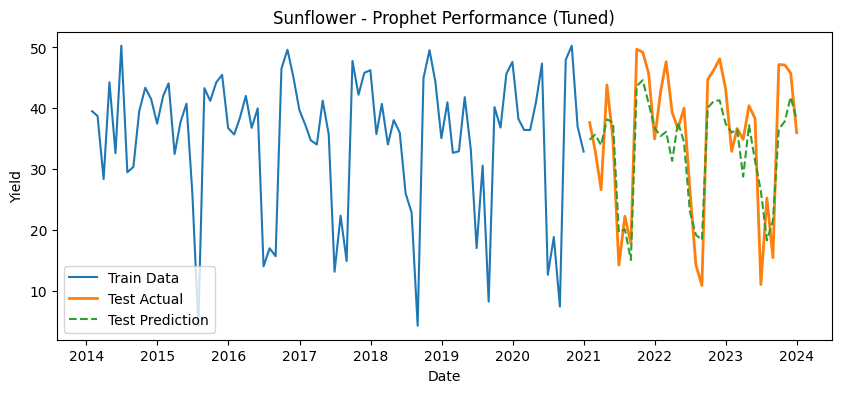

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/mlf7npw1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/7xwpfdc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46421', 'data', 'file=/tmp/tmplw8vkpj5/mlf7npw1.json', 'init=/tmp/tmplw8vkpj5/7xwpfdc5.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modellz8lp5_a/prophet_model-20251111093813.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:38:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Saved Prophet model for Sunflower at prophet_models/Sunflower_prophet.pkl

📊 Processing crop: Barley


09:38:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/rdx6qgem.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/gk0oub30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78895', 'data', 'file=/tmp/tmplw8vkpj5/rdx6qgem.json', 'init=/tmp/tmplw8vkpj5/gk0oub30.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modeljigu3ngp/prophet_model-20251111093813.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:38:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:38:14 - cmdstanpy - INFO - Chain [1]

⚠️ No best model selected via CV for Barley, defaulting to basic Prophet model.


09:38:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


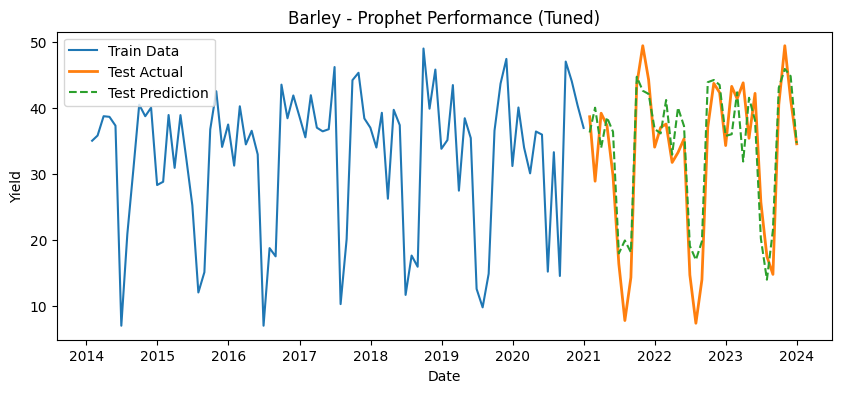

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/o4e4xyil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/mf48hcny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30846', 'data', 'file=/tmp/tmplw8vkpj5/o4e4xyil.json', 'init=/tmp/tmplw8vkpj5/mf48hcny.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modelc9185ye3/prophet_model-20251111093824.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:38:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Saved Prophet model for Barley at prophet_models/Barley_prophet.pkl

📊 Processing crop: Tomato


09:38:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/kbdneqez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/bqn9rlfr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70740', 'data', 'file=/tmp/tmplw8vkpj5/kbdneqez.json', 'init=/tmp/tmplw8vkpj5/bqn9rlfr.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modelzbtadco0/prophet_model-20251111093824.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:38:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:38:25 - cmdstanpy - INFO - Chain [1]

⚠️ No best model selected via CV for Tomato, defaulting to basic Prophet model.


09:38:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


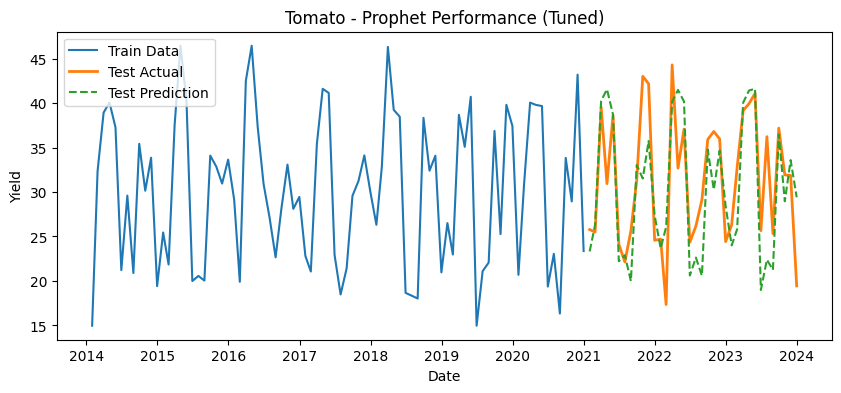

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/afxw1cof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/8khns6r5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14004', 'data', 'file=/tmp/tmplw8vkpj5/afxw1cof.json', 'init=/tmp/tmplw8vkpj5/8khns6r5.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modelseovf1il/prophet_model-20251111093836.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:38:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


✅ Saved Prophet model for Tomato at prophet_models/Tomato_prophet.pkl

📊 Processing crop: Potato


09:38:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/nlzu4xhj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw8vkpj5/hw27_kzx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39323', 'data', 'file=/tmp/tmplw8vkpj5/nlzu4xhj.json', 'init=/tmp/tmplw8vkpj5/hw27_kzx.json', 'output', 'file=/tmp/tmplw8vkpj5/prophet_modelbo7wbdxo/prophet_model-20251111093836.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:38:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:38:37 - cmdstanpy - INFO - Chain [1]

⚠️ No best model selected via CV for Potato, defaulting to basic Prophet model.


09:38:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


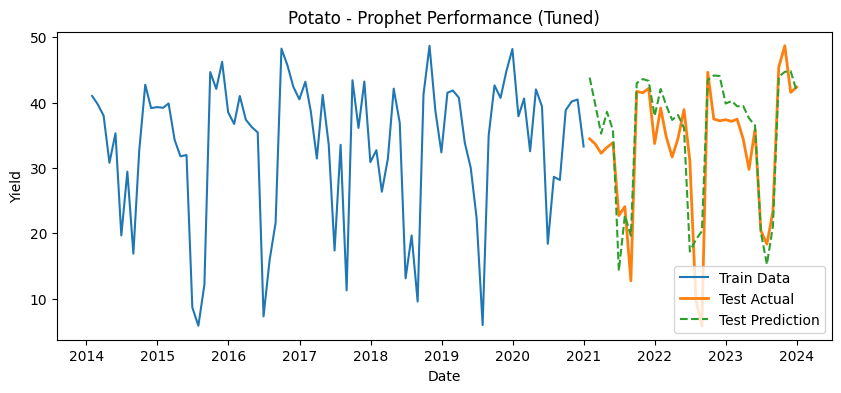

✅ Saved Prophet model for Potato at prophet_models/Potato_prophet.pkl

✅ STEP 3 Completed — Tuned Model Performance Summary:

   Crop Name       MAE        MSE      RMSE  MAPE (%)     R²
7     Barley  4.367491  29.383301  5.420637     20.97  0.784
1       Corn  4.755149  38.032349  6.167037     19.94  0.767
6  Sunflower  5.412223  38.525150  6.206863     20.20  0.718
0     Cotton  5.246759  50.333404  7.094604     27.24  0.690
9     Potato  4.426186  31.348955  5.599014     21.94  0.675
5       Rice  5.753525  51.374578  7.167606     19.16  0.637
2    Soybean  4.465164  48.390008  6.956293     15.09  0.529
4  Sugarcane  5.241920  47.661581  6.903737     13.88  0.470
8     Tomato  4.222402  30.617646  5.533321     14.57  0.395
3      Wheat  4.706001  69.843309  8.357231     14.73  0.360


In [36]:
# ===================== STEP 3: Prophet with Hyperparameter Tuning and Model Saving =====================

import pandas as pd
import glob
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

folder = "monthly_series_by_crop"
files = glob.glob(folder + "/*.csv")

results = []
FORECAST_HORIZON = 36  # last 36 months for testing

# Folder to save models
save_folder = "prophet_models"
os.makedirs(save_folder, exist_ok=True)

# Candidate hyperparameters to try
changepoint_values = [0.05, 0.1, 0.3, 0.5]
seasonality_values = [1, 5, 10, 15]

for file in files:
    df = pd.read_csv(file)
    crop_name = file.split("/")[-1].replace("_monthly.csv", "").replace("_", " ")
    print(f"\n📊 Processing crop: {crop_name}")

    # Ensure proper datetime format and sort
    df["ds"] = pd.to_datetime(df["ds"])
    df = df.sort_values("ds")

    # --- Handle missing dates ---
    df = df.set_index("ds").asfreq("ME")  # Fill missing month-end dates
    df['y'] = df['y'].interpolate()      # Linear interpolation

    # --- Cap outliers ---
    lower = df['y'].quantile(0.01)
    upper = df['y'].quantile(0.99)
    df['y'] = df['y'].clip(lower, upper)

    if len(df) <= FORECAST_HORIZON + 12:
        print(f"⏭️ Skipping {crop_name}: Not enough data")
        continue

    train = df.iloc[:-FORECAST_HORIZON].reset_index()
    test = df.iloc[-FORECAST_HORIZON:].reset_index()

    # --- Hyperparameter tuning using simple grid search ---
    best_cv_score = np.inf
    best_model = None

    for cps in changepoint_values:
        for sps in seasonality_values:
            model = Prophet(yearly_seasonality=True, seasonality_mode="multiplicative",
                            changepoint_prior_scale=cps,
                            seasonality_prior_scale=sps)
            model.fit(train)

            # --- Cross-validation ---
            if len(train) < 36 * 30 + 12 * 30:  # If too short, skip CV
                current_cv_score = np.inf
            else:
                df_cv = cross_validation(
                    model,
                    initial='1080 days',   # 36 months ≈ 36*30 days
                    period='360 days',     # 12 months ≈ 360 days
                    horizon='360 days',
                    parallel="processes"
                )
                df_p = performance_metrics(df_cv, metrics=['rmse'])
                current_cv_score = df_p['rmse'].mean()

            if current_cv_score < best_cv_score:
                best_cv_score = current_cv_score
                best_model = model

    # Default to basic model if no best model selected
    if best_model is None:
        print(f"⚠️ No best model selected via CV for {crop_name}, defaulting to basic Prophet model.")
        best_model = Prophet(yearly_seasonality=True, seasonality_mode="multiplicative")
        best_model.fit(train)

    # --- Predict with best model ---
    future = best_model.make_future_dataframe(periods=FORECAST_HORIZON, freq="ME")
    forecast = best_model.predict(future)
    pred = forecast.set_index("ds").loc[test["ds"], "yhat"]

    # --- Evaluation Metrics ---
    test_y_aligned = test.set_index("ds").loc[pred.index, "y"]
    mae = mean_absolute_error(test_y_aligned, pred)
    mse = mean_squared_error(test_y_aligned, pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_y_aligned - pred) / (test_y_aligned + 1e-9))) * 100
    r2 = r2_score(test_y_aligned, pred)

    results.append([crop_name, mae, mse, rmse, round(mape,2), round(r2,3)])

    # --- Plot Train vs Test vs Prediction ---
    plt.figure(figsize=(10,4))
    plt.plot(train["ds"], train["y"], label="Train Data")
    plt.plot(test["ds"], test["y"], label="Test Actual", linewidth=2)
    plt.plot(test["ds"], pred, label="Test Prediction", linestyle="--")
    plt.title(f"{crop_name} - Prophet Performance (Tuned)")
    plt.xlabel("Date")
    plt.ylabel("Yield")
    plt.legend()
    plt.show()

    # --- Save model as .pkl ---
    model_filename = os.path.join(save_folder, f"{crop_name.replace(' ','_')}_prophet.pkl")
    joblib.dump(best_model, model_filename)
    print(f"✅ Saved Prophet model for {crop_name} at {model_filename}")

# --- Summary Table ---
performance_df = pd.DataFrame(results, columns=["Crop Name", "MAE", "MSE", "RMSE", "MAPE (%)", "R²"])
print("\n✅ STEP 3 Completed — Tuned Model Performance Summary:\n")
print(performance_df.sort_values("R²", ascending=False))


In [38]:
from google.colab import drive
import os
import joblib

# 1️⃣ Mount Google Drive


# 2️⃣ Folder in Google Drive to save models
save_folder = "/content/drive/MyDrive/prophet_models"
os.makedirs(save_folder, exist_ok=True)

# --- Inside your loop, after training each best_model ---
for file in files:
    df = pd.read_csv(file)
    crop_name = file.split("/")[-1].replace("_monthly.csv", "").replace("_", " ")

    # ... [all preprocessing, tuning, training code here] ...

    # 3️⃣ Save the trained Prophet model with unique name
    model_filename = os.path.join(save_folder, f"{crop_name.replace(' ','_')}_prophet.pkl")
    joblib.dump(best_model, model_filename)
    print(f"✅ Saved Prophet model for {crop_name} at {model_filename}")


✅ Saved Prophet model for Cotton at /content/drive/MyDrive/prophet_models/Cotton_prophet.pkl
✅ Saved Prophet model for Corn at /content/drive/MyDrive/prophet_models/Corn_prophet.pkl
✅ Saved Prophet model for Soybean at /content/drive/MyDrive/prophet_models/Soybean_prophet.pkl
✅ Saved Prophet model for Wheat at /content/drive/MyDrive/prophet_models/Wheat_prophet.pkl
✅ Saved Prophet model for Sugarcane at /content/drive/MyDrive/prophet_models/Sugarcane_prophet.pkl
✅ Saved Prophet model for Rice at /content/drive/MyDrive/prophet_models/Rice_prophet.pkl
✅ Saved Prophet model for Sunflower at /content/drive/MyDrive/prophet_models/Sunflower_prophet.pkl
✅ Saved Prophet model for Barley at /content/drive/MyDrive/prophet_models/Barley_prophet.pkl
✅ Saved Prophet model for Tomato at /content/drive/MyDrive/prophet_models/Tomato_prophet.pkl
✅ Saved Prophet model for Potato at /content/drive/MyDrive/prophet_models/Potato_prophet.pkl
